In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import feature_column 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DATASET ANALYSIS AND PREPROCESSING

In [38]:
df = pd.read_csv("CreditCardDataset.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57355 entries, 0 to 57354
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    57355 non-null  int64  
 1   V1      57355 non-null  float64
 2   V2      57355 non-null  float64
 3   V3      57355 non-null  float64
 4   V4      57355 non-null  float64
 5   V5      57355 non-null  float64
 6   V6      57355 non-null  float64
 7   V7      57355 non-null  float64
 8   V8      57355 non-null  float64
 9   V9      57355 non-null  float64
 10  V10     57355 non-null  float64
 11  V11     57355 non-null  float64
 12  V12     57355 non-null  float64
 13  V13     57355 non-null  float64
 14  V14     57355 non-null  float64
 15  V15     57355 non-null  float64
 16  V16     57355 non-null  float64
 17  V17     57355 non-null  float64
 18  V18     57355 non-null  float64
 19  V19     57355 non-null  float64
 20  V20     57355 non-null  float64
 21  V21     57355 non-null  float64
 22

In [40]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No null values in data.

In [41]:
df['Class'].nunique()

2

In [42]:
df.Class.value_counts()

0    56863
1      492
Name: Class, dtype: int64

<AxesSubplot:>

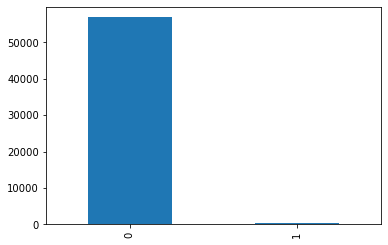

In [43]:
df.Class.value_counts().plot.bar()

This shows a complete imbalance in classes.

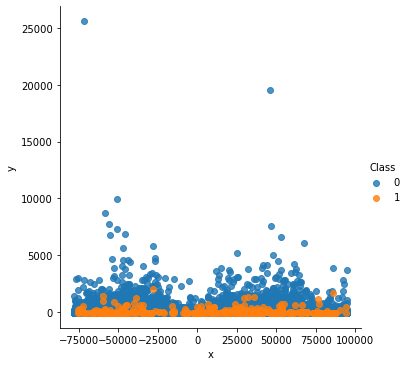

In [44]:
#PCA is performed for visualization
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
creditcard_2d= pd.DataFrame(pca.fit_transform(df.iloc[:,0:30]))
creditcard_2d= pd.concat([creditcard_2d, df['Class']], axis=1)
creditcard_2d.columns= ['x', 'y', 'Class']
sns.lmplot(x='x', y='y', data=creditcard_2d, fit_reg=False, hue='Class')

In [45]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,...,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000
mean,94577.357074,-0.029092,0.030156,-0.055749,0.035521,-0.022664,-0.006869,-0.032448,0.006142,-0.017667,...,0.005569,-0.000265,0.003273,0.001159,0.005003,0.003133,0.000226,-0.000625,88.825575,0.008578
std,47505.713234,2.061391,1.711228,1.733364,1.484621,1.508300,1.361819,1.504317,1.334058,1.131679,...,0.813950,0.734597,0.625238,0.604653,0.519852,0.482496,0.433713,0.323980,279.496913,0.092221
min,2.000000,-36.802320,-63.344698,-48.325589,-5.519697,-113.743307,-19.996349,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-32.828995,-2.822384,-8.696627,-2.534330,-8.878665,-15.430084,0.000000,0.000000
25%,53943.500000,-0.927615,-0.588747,-0.922554,-0.839400,-0.692157,-0.774796,-0.558211,-0.207145,-0.651869,...,-0.226932,-0.541278,-0.161812,-0.354648,-0.312164,-0.322536,-0.070642,-0.052695,5.475000,0.000000
50%,84641.000000,0.015980,0.071801,0.168619,-0.005637,-0.055913,-0.276163,0.035797,0.024380,-0.053373,...,-0.028379,0.004681,-0.011439,0.041286,0.021494,-0.049135,0.000859,0.011169,21.990000,0.000000
75%,139140.000000,1.314129,0.815413,1.019384,0.764271,0.607021,0.387408,0.562758,0.333358,0.599522,...,0.190245,0.529286,0.147282,0.439244,0.352590,0.243882,0.091355,0.078500,76.900000,0.000000
max,172777.000000,2.454930,22.057729,3.940337,16.715537,28.762671,73.301626,120.589494,20.007208,10.348407,...,27.202839,10.503090,22.528412,4.584549,5.826159,3.517346,31.612198,15.866721,25691.160000,1.000000


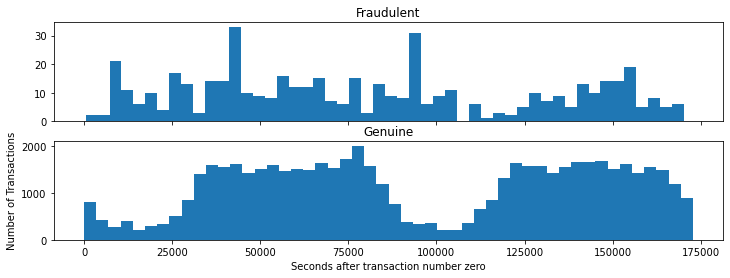

In [46]:
#Histrogram for feature Time
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(df["Time"][df["Class"] == 1], bins = 50)
ax1.set_title('Fraudulent')

ax2.hist(df["Time"][df["Class"] == 0], bins = 50)
ax2.set_title('Genuine')

plt.xlabel('Seconds after transaction number zero')
plt.ylabel('Number of Transactions')
plt.show()

Time feature does not provide any useful information as the time when the first transaction was initiated is not given. Thus, we'll drop this feature.

In [47]:
creditcard_data = df.drop("Time", axis = 1)

Descriptive statistics for Genuine Transactions

In [48]:
print("Genuine Transactions")
creditcard_data['Amount'][creditcard_data['Class']==0]. describe()


Genuine Transactions


count    56863.000000
mean        88.536709
std        279.670869
min          0.000000
25%          5.540000
50%         22.000000
75%         76.230000
max      25691.160000
Name: Amount, dtype: float64

Descriptive statistics for Fraudulent Transactions

In [49]:
print("Fraudulent Transactions")
creditcard_data['Amount'][creditcard_data['Class']==1]. describe()

Fraudulent Transactions


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [50]:
#Variance
creditcard_data.var()

V1            4.249332
V2            2.928302
V3            3.004550
V4            2.204100
V5            2.274969
V6            1.854551
V7            2.262969
V8            1.779711
V9            1.280698
V10           1.561217
V11           1.176319
V12           1.404513
V13           0.999567
V14           1.375218
V15           0.835668
V16           0.985969
V17           1.359197
V18           0.788821
V19           0.672169
V20           0.676008
V21           0.662515
V22           0.539633
V23           0.390922
V24           0.365605
V25           0.270246
V26           0.232803
V27           0.188107
V28           0.104963
Amount    78118.524128
Class         0.008505
dtype: float64

Robust Scaler to scale the feature 'Amount'. All other 'V' columns are already scaled as they've undergone PCA transformation.

In [51]:
from sklearn.preprocessing import RobustScaler
Rob_scaler=RobustScaler() #Robust to outliers
creditcard_data['Std_Amount'] = Rob_scaler.fit_transform(creditcard_data['Amount'].values.reshape(-1, 1))
creditcard_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Std_Amount
0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.672034
1,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,-0.256493
2,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0,0.263353
3,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,0.460230,...,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0,0.077144
4,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,0.747731,...,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0,-0.084004


In [52]:
#dropping Amount and moveing Std_Amount at index '0'
creditcard_data = creditcard_data.drop('Amount',axis=1)

Std_Amount = creditcard_data['Std_Amount']
creditcard_data.drop('Std_Amount', axis=1, inplace=True)
creditcard_data.insert(0, 'Std_Amount', Std_Amount)
creditcard_data.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.672034,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
1,-0.256493,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0
2,0.263353,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0
3,0.077144,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.153197,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,0
4,-0.084004,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.263451,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,0


### Splitting Data

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

X = creditcard_data.drop('Class', axis=1)
Y = creditcard_data['Class']

sss1 = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index1, test_index in sss1.split(X, Y):
    print("Train:", train_index1, "Test:", test_index)
    Xtrain, Xtest = X.iloc[train_index1], X.iloc[test_index]
    Ytrain, Ytest = Y.iloc[train_index1], Y.iloc[test_index]

sss2 = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

for train_index2, val_index in sss2.split(Xtrain, Ytrain):
    print("Train:", train_index2, "Validation:", val_index)
    Xtrain_final, Xval = X.iloc[train_index2], X.iloc[val_index]
    Ytrain_final, Yval = Y.iloc[train_index2], Y.iloc[val_index]

Train: [39373 38008  2461 ... 22816 53547 10515] Test: [21887  5012 10570 ... 10851 27997 48334]
Train: [33790 41761 34229 ... 28198 29880 52162] Test: [55765 33905 48958 ... 52057 14195 34286]
Train: [ 4586  8864 57008 ... 31722 51042 21575] Test: [44556 25276 22757 ... 40016 23182 38114]
Train: [30290 30118 30931 ...   993 17838 57197] Test: [ 5068 10416  3744 ...   539 48861 49331]
Train: [ 6075 45361 37281 ...  4545 17001 47516] Test: [33502  7565 46291 ... 51573 53360 27784]
Train: [ 6020 37624 10769 ... 37091 10703 41819] Validation: [43222 21681  4512 ... 35343 22253 36021]
Train: [31654 36691 41449 ... 26428 15363  7088] Validation: [35014 42012 17068 ... 15788 40546 18046]
Train: [28088 21579 12556 ... 19670 29724 31716] Validation: [31949   919 34637 ... 28387 24737 43768]
Train: [31639 40820 24291 ... 22634 16065  1968] Validation: [41490 33239  2377 ... 40134  7978 10068]
Train: [33797 33729 19231 ... 45538 35886 15208] Validation: [20814  8530 17438 ...  8757 34935 32979]


Checking lables after split.

In [54]:
train_unique_label, train_counts_label = np.unique(Ytrain_final, return_counts=True)
test_unique_label, test_counts_label = np.unique(Ytest, return_counts=True)
val_unique_label, val_counts_label = np.unique(Yval, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(Ytrain_final))
print(test_counts_label/ len(Ytest))
print(val_counts_label/ len(Yval))

Label Distributions: 

[0.99087554 0.00912446]
[0.99145672 0.00854328]
[0.99102084 0.00897916]


In [55]:
print(Xtrain_final.shape)
print(Ytrain_final.shape)
print(Xtest.shape)
print(Ytest.shape)
print(Xval.shape)
print(Yval.shape)

(34413, 29)
(34413,)
(11471, 29)
(11471,)
(11471, 29)
(11471,)


### Using ADASYN for over sampling.

In [56]:
ada = ADASYN(sampling_strategy='minority', random_state=42)

X_adasampled, Y_adasampled = ada.fit_resample(Xtrain_final, Ytrain_final)
print('Resampled dataset shape %s' % Counter(Y_adasampled))
print('Shape of X_adasampled: {}'.format(X_adasampled.shape))
print('Shape of Y_adasampled: {}'.format(Y_adasampled.shape))

Resampled dataset shape Counter({1: 34119, 0: 34099})
Shape of X_adasampled: (68218, 29)
Shape of Y_adasampled: (68218,)


In [57]:
#checking the disribution of both the labels
train_label, train_count = np.unique(Y_adasampled, return_counts=True)
print('Label Distributions: \n')
print(train_count/ len(Y_adasampled))

Label Distributions: 

[0.49985341 0.50014659]


In [58]:
#Converting to array
X_adasampled_ar = np.array(X_adasampled)
X_test_ar = np.array(Xtest)
X_val_ar = np.array(Xval)
y_val_ar = np.array(Yval)
y_adasampled_ar = np.array(Y_adasampled)
y_test_sm_ar = np.array(Ytest)

### Loading Data into Tensor.

In [59]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_adasampled_ar), torch.from_numpy(y_adasampled_ar)), 
                          batch_size=len(X_adasampled), shuffle=True)

test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test_ar), torch.from_numpy(y_test_sm_ar)), 
                         batch_size=len(X_adasampled), shuffle=False)

val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_ar), torch.from_numpy(y_val_ar)), 
                         batch_size=len(Xval), shuffle=False)

data_loaders = {"train": train_loader,
               "test": test_loader,
               "validation": val_loader}

### Defining Neural Network.

In [60]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(29, 340) #28 xs
        self.fc2 = nn.Linear(340,220) # hidden layers with 340 and 220 neurons each
        self.fc3 = nn.Linear(220, 200)
        self.fc4 = nn.Linear(200,70)
        self.fc5 = nn.Linear(70,10)
        self.fc6 = nn.Linear(10,2) # two responses - 0 or 1
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,out):
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.dropout(F.relu(self.fc5(out)))
        out = F.log_softmax(self.fc6(out),dim=1)
        
        return out

In [61]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [62]:
model

Classifier(
  (fc1): Linear(in_features=29, out_features=340, bias=True)
  (fc2): Linear(in_features=340, out_features=220, bias=True)
  (fc3): Linear(in_features=220, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=70, bias=True)
  (fc5): Linear(in_features=70, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Accuracy

In [63]:
def predict(model, inputs):
    output = model(inputs)
    return output.data.numpy().argmax(axis=1)

In [64]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [65]:
loss1 = []
val_loss1=[]
train_acc = []
val_acc=[]
Epoch = 200

print("Begin Training")
for epoch in tqdm(range(Epoch)):
    
    # training
    acc = 0
    train_acc1=0
    train_epoch_loss=0
    
    for i, (features, labels) in enumerate(train_loader):
        
        features = Variable(features)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        features = features.float()
        outputs = model(features)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        
        if (i+1) % len(train_loader) == 0:
            y_pred = predict(model, torch.from_numpy(X_adasampled_ar).float())
            acc = np.mean(y_adasampled_ar == y_pred)
            
            train_acc1 = acc/len(train_loader)
            train_acc.append(train_acc1)
            loss1.append(loss.data)
            
    # validation
    val_acc = 0
    val_acc1=0
    val_epoch_loss=0
    with torch.no_grad():
            for i, (val_features, val_labels) in enumerate(val_loader):
                val_features = Variable(val_features)
                val_labels = Variable(val_labels)
        
                val_features = val_features.float()
                val_outputs = model(val_features)
                val_loss = criterion(val_outputs, val_labels.long())        
                optimizer.step()
        
                val_epoch_loss += val_loss.item()
        
                if (i+1) % len(val_loader) == 0:
                    y_pred_val = predict(model, torch.from_numpy(X_val_ar).float())
                    val_acc = np.mean(Yval == y_pred_val)
            
                    val_acc1 = val_acc/len(val_loader)
                    val_acc += val_acc1.item()
                    val_loss1.append(val_loss.data)
                    
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
            loss_stats['val'].append(val_epoch_loss/len(val_loader))
            accuracy_stats['train'].append(train_acc1/len(train_loader))
            accuracy_stats['val'].append(val_acc1/len(val_loader))
            
            print(f'Epoch {epoch+1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_acc1:.3f} | Val acc: {val_acc1:.3f} ')

Begin Training


Epoch 1: | Train Loss: 0.71209 | Val loss: 1.10296 | Train Acc: 0.500 | Val acc: 0.013 
Epoch 2: | Train Loss: 1.23224 | Val loss: 0.72361 | Train Acc: 0.641 | Val acc: 0.795 
Epoch 3: | Train Loss: 0.84680 | Val loss: 0.65991 | Train Acc: 0.641 | Val acc: 0.511 
Epoch 4: | Train Loss: 0.64933 | Val loss: 0.70322 | Train Acc: 0.741 | Val acc: 0.613 
Epoch 5: | Train Loss: 0.58715 | Val loss: 0.59293 | Train Acc: 0.827 | Val acc: 0.831 
Epoch 6: | Train Loss: 0.43598 | Val loss: 0.38689 | Train Acc: 0.886 | Val acc: 0.901 
Epoch 7: | Train Loss: 0.29806 | Val loss: 0.25249 | Train Acc: 0.900 | Val acc: 0.936 
Epoch 8: | Train Loss: 0.30769 | Val loss: 0.24585 | Train Acc: 0.924 | Val acc: 0.926 
Epoch 9: | Train Loss: 0.24328 | Val loss: 0.22461 | Train Acc: 0.940 | Val acc: 0.940 
Epoch 10: | Train Loss: 0.17107 | Val loss: 0.13033 | Train Acc: 0.947 | Val acc: 0.955 
Epoch 11: | Train Loss: 0.15694 | Val loss: 0.11602 | Train Acc: 0.967 | Val acc: 0.931 
Epoch 12: | Train Loss: 0.1253

Epoch 94: | Train Loss: 0.01501 | Val loss: 0.08758 | Train Acc: 0.996 | Val acc: 0.990 
Epoch 95: | Train Loss: 0.01452 | Val loss: 0.10400 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 96: | Train Loss: 0.01512 | Val loss: 0.10046 | Train Acc: 0.996 | Val acc: 0.987 
Epoch 97: | Train Loss: 0.01425 | Val loss: 0.09961 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 98: | Train Loss: 0.01478 | Val loss: 0.10409 | Train Acc: 0.996 | Val acc: 0.990 
Epoch 99: | Train Loss: 0.01454 | Val loss: 0.11321 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 100: | Train Loss: 0.01421 | Val loss: 0.12103 | Train Acc: 0.996 | Val acc: 0.990 
Epoch 101: | Train Loss: 0.01439 | Val loss: 0.11935 | Train Acc: 0.996 | Val acc: 0.987 
Epoch 102: | Train Loss: 0.01408 | Val loss: 0.11074 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 103: | Train Loss: 0.01490 | Val loss: 0.10781 | Train Acc: 0.996 | Val acc: 0.990 
Epoch 104: | Train Loss: 0.01394 | Val loss: 0.09074 | Train Acc: 0.995 | Val acc: 0.991 
Epoch 105: | Tra

Epoch 186: | Train Loss: 0.01314 | Val loss: 0.14436 | Train Acc: 0.996 | Val acc: 0.988 
Epoch 187: | Train Loss: 0.01232 | Val loss: 0.15581 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 188: | Train Loss: 0.01233 | Val loss: 0.15866 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 189: | Train Loss: 0.01268 | Val loss: 0.12087 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 190: | Train Loss: 0.01213 | Val loss: 0.13054 | Train Acc: 0.996 | Val acc: 0.990 
Epoch 191: | Train Loss: 0.01213 | Val loss: 0.14705 | Train Acc: 0.995 | Val acc: 0.989 
Epoch 192: | Train Loss: 0.01223 | Val loss: 0.14647 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 193: | Train Loss: 0.01261 | Val loss: 0.14735 | Train Acc: 0.996 | Val acc: 0.989 
Epoch 194: | Train Loss: 0.01273 | Val loss: 0.15294 | Train Acc: 0.996 | Val acc: 0.990 
Epoch 195: | Train Loss: 0.01189 | Val loss: 0.16767 | Train Acc: 0.995 | Val acc: 0.989 
Epoch 196: | Train Loss: 0.01328 | Val loss: 0.16464 | Train Acc: 0.996 | Val acc: 0.990 
Epoch 197:

Acuracy of Actual Test data wit prediction.

In [66]:
y_pred = predict(model, torch.from_numpy(X_test_ar).float())
acc = np.mean(Ytest == y_pred)
print("Test accuracy: ", acc)

Test accuracy:  0.9894516607096155


Vizualizing Train and Validation Accuracy and Loss.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

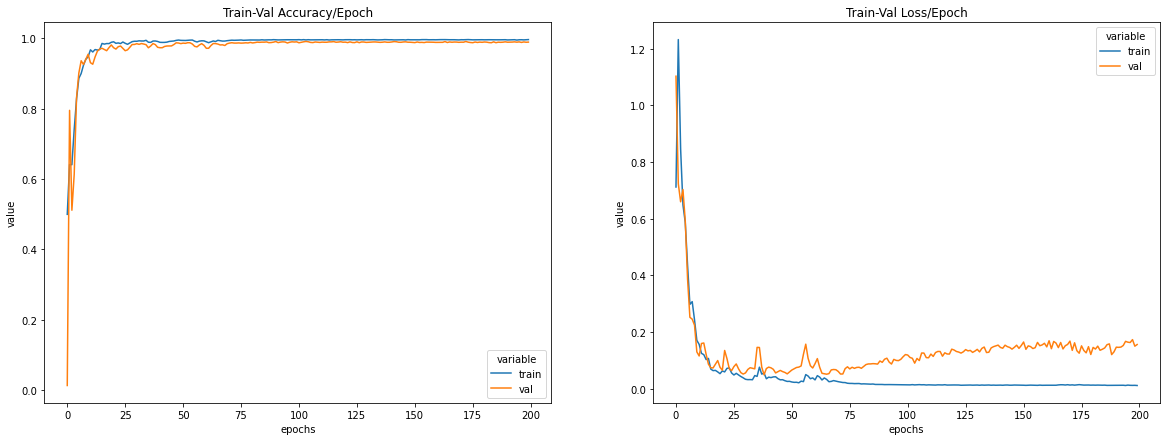

In [67]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [68]:
target_names = ['Class 0', 'Class 1']
print(classification_report(Ytest, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99     11373
     Class 1       0.44      0.91      0.60        98

    accuracy                           0.99     11471
   macro avg       0.72      0.95      0.79     11471
weighted avg       0.99      0.99      0.99     11471



# Conclusion

The moodel implemented fot creditcard fraud ditection uising Nural Network with Tensor flow.

The model shows simmilar Train-Validation accuracy, and Train-Validation loss has no major diffrence. The overall accuracy of odel is 0.99 which is reallu good.